<a href="https://colab.research.google.com/github/putriayualc/Machine-Learning/blob/main/Jobsheet-10/Praktikum%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Putri Ayu Aliciawati  
Kelas : TI-3C  
NIM : 2241720132  
Github : https://github.com/putriayualc/Machine-Learning


# Praktikum 1

## Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Not a movie, but a lip synched collection of performances from acts that were part of the British Invasion, that followed the dynamic entrance of the Beatles to the music world. Some of these acts did not make a big splash on this side of the pond, but a lot of them did. Featured are: Herman's Hermits, Billy J. Kramer and the Dakotas, Peter and Gordon, Honeycombs, Nashville Teens, Animals, and of course,the Beatles.<br /><br />It is so much fun watching these young acts before they honed and polished their acts."
 b"I thought this movie was excellent,for the fact that Corrine and Sean are newcomers to the business.It was packed with action and a little romance,but there were some points when Corrine didn't speak very clearly (when she threatened Sean with the gun) and she clenched her teeth...maybe she was supposed to?I think the roles of Joseph and Sonny were portrayed very well,and there was an obvious contrast.Also,because i watched next action star,i am certain that Corr

## Buat Teks Encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 22,   4,  18, ...,   0,   0,   0],
       [ 10, 199,  11, ...,   0,   0,   0],
       [  2,   1,   7, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Not a movie, but a lip synched collection of performances from acts that were part of the British Invasion, that followed the dynamic entrance of the Beatles to the music world. Some of these acts did not make a big splash on this side of the pond, but a lot of them did. Featured are: Herman's Hermits, Billy J. Kramer and the Dakotas, Peter and Gordon, Honeycombs, Nashville Teens, Animals, and of course,the Beatles.<br /><br />It is so much fun watching these young acts before they honed and polished their acts."
Round-trip:  not a movie but a [UNK] [UNK] [UNK] of performances from [UNK] that were part of the british [UNK] that [UNK] the [UNK] [UNK] of the [UNK] to the music world some of these [UNK] did not make a big [UNK] on this side of the [UNK] but a lot of them did [UNK] are [UNK] [UNK] [UNK] [UNK] [UNK] and the [UNK] peter and [UNK] [UNK] [UNK] [UNK] [UNK] and of [UNK] [UNK] br it is so much fun watching these young [UNK] before they [UNK] and [UNK] their [UNK]    

## Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(text):
    return tf.data.Dataset.from_tensor_slices([text]).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
dataset = create_dataset(sample_text)

# Prediksi menggunakan model
predictions = model.predict(dataset)
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00108534]


In [ ]:
# Fungsi untuk memproses teks menjadi dataset
def create_dataset(texts):
    return tf.data.Dataset.from_tensor_slices(texts).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
padding = "the " * 2000  # Padding text
texts = [sample_text, padding]  # List of texts including padding

# Membuat dataset dari teks
dataset = create_dataset(texts)

# Prediksi menggunakan model
predictions = model.predict(dataset)
for pred in predictions:
  print(pred)

2/2 [==============================] - 0s 93ms/step
[-0.00108534]
[0.01956253]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 240s 596ms/step - loss: 0.6472 - accuracy: 0.5555 - val_loss: 0.5206 - val_accuracy: 0.6536
Epoch 2/10
391/391 [==============================] - 226s 577ms/step - loss: 0.4317 - accuracy: 0.7946 - val_loss: 0.3840 - val_accuracy: 0.8151
Epoch 3/10
391/391 [==============================] - 223s 570ms/step - loss: 0.3558 - accuracy: 0.8423 - val_loss: 0.3476 - val_accuracy: 0.8422
Epoch 4/10
391/391 [==============================] - 221s 564ms/step - loss: 0.3299 - accuracy: 0.8538 - val_loss: 0.3482 - val_accuracy: 0.8370
Epoch 5/10
391/391 [==============================] - 221s 565ms/step - loss: 0.3167 - accuracy: 0.8617 - val_loss: 0.3427 - val_accuracy: 0.8286
Epoch 6/10
391/391 [==============================] - 223s 571ms/step - loss: 0.3121 - accuracy: 0.8663 - val_loss: 0.3422 - val_accuracy: 0.8438
Epoch 7/10
391/391 [==============================] - 222s 568ms/step - loss: 0.3042 - accuracy: 0.8677 - val_loss: 0.3236 -

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 66s 168ms/step - loss: 0.3156 - accuracy: 0.8574
Test Loss: 0.31560632586479187
Test Accuracy: 0.8574000000953674


(0.0, 0.6647171318531037)

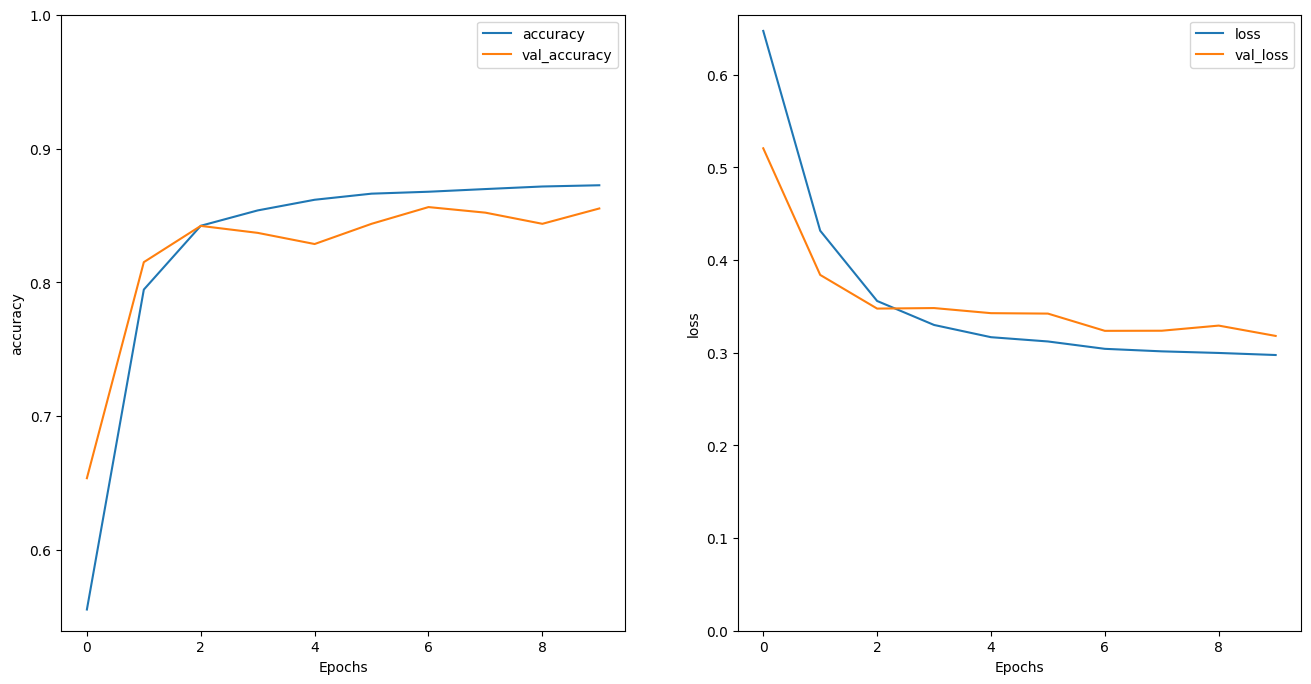

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
            'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 450s 1s/step - loss: 0.6315 - accuracy: 0.5871 - val_loss: 0.4692 - val_accuracy: 0.7781
Epoch 2/10
391/391 [==============================] - 437s 1s/step - loss: 0.3956 - accuracy: 0.8248 - val_loss: 0.3519 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 430s 1s/step - loss: 0.3423 - accuracy: 0.8522 - val_loss: 0.3310 - val_accuracy: 0.8474
Epoch 4/10
391/391 [==============================] - 434s 1s/step - loss: 0.3213 - accuracy: 0.8617 - val_loss: 0.3310 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 430s 1s/step - loss: 0.3135 - accuracy: 0.8652 - val_loss: 0.3253 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 433s 1s/step - loss: 0.3091 - accuracy: 0.8676 - val_loss: 0.3214 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 427s 1s/step - loss: 0.3045 - accuracy: 0.8685 - val_loss: 0.3179 - val_accuracy: 0.8552

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 115s 295ms/step - loss: 0.3179 - accuracy: 0.8596
Test Loss: 0.31791743636131287
Test Accuracy: 0.8596000075340271


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.6194258]]


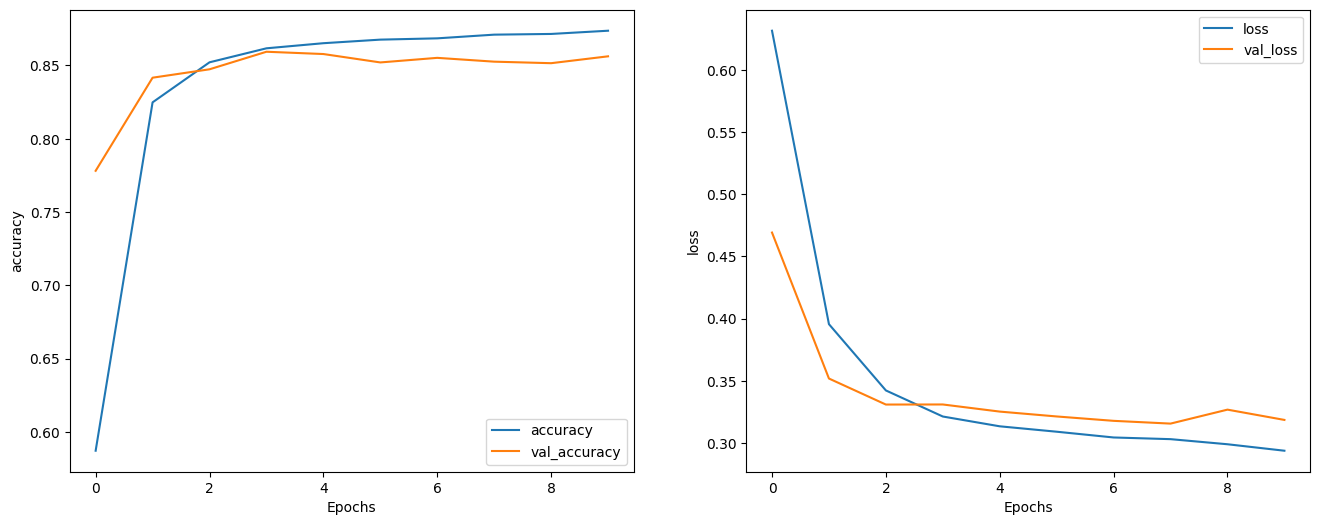

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')